## Gaussian Mixture Models for TIMIT

+ ###### Authors: Dirk Van Compernolle
+ ###### History:  04/2022, 17/03/2023
+ ###### Requires: pyspch v0.7   

Content:
- Training of GMMs for all phonemes
- Frame CLassification
- Applying the models for utterance analysis


In [193]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import requests
import importlib
import urllib.request
import pickle
import gzip
from pyspch.stats import GMM
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)

# print and plot
np.set_printoptions(precision=2)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
import pyspch.nn
from pyspch.stats import GMM
import pyspch.core as Spch

logging.basicConfig(level=logging.INFO)

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

In [2]:
#@title Auxiliary functions 

# download from url and write to file
def write_from_url(url, filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)

# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

# import setup file (.py) as module (dotdict)
def read_setup(filename, new_read_path=None, old_read_path='/users/spraak/spchlab/public_html/data/timit/'):
    
    # load module
    spec = importlib.util.spec_from_file_location(os.path.basename(filename), filename)
    setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(setup)
    
    # convert to dict 
    setup = dict_from_module(setup)
    setup = dotdict(setup)

    # replace esat_path with root_url
    if new_read_path is not None:
        for k, v in setup.items():
            if type(v) == str:
                setup[k] = v.replace(old_read_path, new_read_path)
            
    return setup

In [29]:
# Utility for importing TIMIT data
timit_root = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
def get_timit_data(subcorpus="",ftrs_in="mfcc13",alphabet='timit41',feature_args={}):
    '''
    get (part of) TIMIT corpus from disk
    and process all features for the defined feature extraction
    
    subcorpus:     "", "_mini", "_dr1"   for full, mini(10%), single subdirectory dr1
    ftrs_in:       type of preprocessed features to start from
    alphabet:      choice of alphabet to use  (TIMIT61 should be convertable to it)
    feature_args:  definition of desired feature extraction, should be compatible with  ftrs_in
    '''
    #

    corpus_path = timit_root + 'conf/'
    train_corpus_file = corpus_path + 'timit_train'+subcorpus+'.corpus'
    test_corpus_file = corpus_path + 'timit_test'+subcorpus+'.corpus'
    feature_path = timit_root + 'features/'+ ftrs_in + '/'
    train_pickle_file = feature_path + 'train.pkl'
    test_pickle_file = feature_path + 'test.pkl'
    # read train corpus and features
    train_corpus = pyspch.read_txt(train_corpus_file)
    train_df = pd.read_pickle(train_pickle_file)
    train_data = pyspch.core.DataFrame_to_SpchData(train_df, delete_df=True) 
    train_data = train_data.subset(train_corpus) 
    # read test corpus and features 
    test_corpus = pyspch.read_txt(test_corpus_file)
    test_df = pd.read_pickle(test_pickle_file)
    test_data = pyspch.core.DataFrame_to_SpchData(test_df, delete_df=True) 
    test_data = test_data.subset(test_corpus) 
    ##
    # evaluate what postprocessing is needed en do it
    read_feature_args = pyspch.read_json(feature_path + 'feature_args.json')
    modify_feature_args = pyspch.dct_diff(read_feature_args, feature_args)
    #print(modify_feature_args)
    train_data.modify_features(modify_feature_args)
    test_data.modify_features(modify_feature_args) 
    ##
    # map originial TIMIT 61 transcriptions to the chosen alphabet
    classes = pyspch.timit.get_timit_alphabet(alphabet)
    lab2classes = pyspch.timit.get_timit_mapping('timit61'+'_'+alphabet) 
    train_data.modify_labels(lab2classes) # timit61 -> timit41
    test_data.modify_labels(lab2classes) # timit61 -> timit41
    
    return(train_data,test_data,classes)

In [83]:
# Utilities for classification datasets (X,y) 
def downsample_data_sets(X_in,y_in,downsample=1,mincount=64):
    '''
    downsample an existing dataset (X,y)
    '''
    dim = X_in.shape[1]
    X = np.empty((0,dim),'float64')
    y = np.empty((0,),dtype='<U3')
    labels = np.unique(y)
    for lbl in labels:
        selection = (y_in==lbl)
        n = sum(selection)
        ds = min(downsample, max(1,n//mincount) )
        X = np.vstack((X,X_in[selection][::ds]))
        y = np.concatenate((y,y_in[selection][::ds]))
    return(X,y)

def print_dataset_statistics(y,Details=False,txt="dataset"):
    '''
    print global dataset statistics
    if Details=True, you also get statistics per label
    '''
    labels = np.unique(y)
    print("Statistics for %s:" % txt)
    print("Number of classes",len(labels))
    print("Number of samples",len(y)) 
    samples_per_class = [ sum(y==lbl) for lbl in labels ]
    print("Minimun/Maximum number of samples per class: ",np.min(samples_per_class), ' / ',np.max(samples_per_class))
    if(Details):
        print([ (labels[i],samples_per_class[i]) for i in range(len(labels)) ] )
        
# utilities for saving and retrieving models from pickle files
def save_pickle(data,filename):
    picklefile = open(filename, 'wb')
    pickle.dump(data, picklefile),
    picklefile.close()    
def get_pickle(filename):
    picklefile = open(filename, 'rb')
    data = pickle.load(picklefile)
    picklefile.close()
    return(data)

In [194]:
def plot_probs(probs, labels,  fig, iax=2, x0=0., title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## !! only works properly for starting frame = 0
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,linewidths=1,linecolor='k')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.])
        fig.axes[iax].legend(labels, loc='center right')  # , ncol=15)
    ax.set_title(title)

### Get TIMIT Data and do Feature Extraction

***... READING THE DATA FROM DISK/URL CAN TAKE A FEW MINUTES !! ...*** 

##### TIMIT database
This notebook works with the TIMIT database.
Most experiments can be performed well with the "mini"-subcorpus.

The phonetic targets are 41 phonetic symbols, i.e. the CMU-39 set + silence + closure.    
The original TIMIT transcriptions use 61 symbols which are mapped to our 41 symbol set

##### Feature Extraction
In these experiments we use Mel Frequency Cepstral Coefficients, that are obtained by following pipeline:
- Spectral Magnitude  (256 coeff)
- MEL Filterbank (24)
- CEPSTRAL coefficients (13)
- addition of Delta features (26)
- mean and variance normalization per sentence (26)

For convenience we read the raw static MFCC (13D) coefficients from disk.  
In the postprocessing we add the dynamic (delta) features and we perform mean and variance normalization. 

In [5]:
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}

train_data, test_data, classes = get_timit_data(subcorpus="_mini",ftrs_in="mfcc13",alphabet='timit41',feature_args=feature_args)

In [6]:
# Put training data and labels  in numpy/sklearn (X,y) format
# input features
X_train_db = train_data.get_features_as_numpy() 
X_test_db = test_data.get_features_as_numpy() 
# labels
y_train_db = train_data.get_labels_as_numpy()
y_test_db = test_data.get_labels_as_numpy() 

#### Database Analysis
Verify the distribution of Observations per class
You will note that the training data is heavily skewed.
It just happens to be that some phonemes are way more frequent than others.  
Moreover the average length of a phoneme plays a role as we take each frame as an observation and just look for the corresponding label in the TIMIT transcriptions.
Some phonemes thus have thousands of examples available for training, while others (e.g. 'zh') are only marginally represented.  
The biggest class is 'sil' with 200k+ samples, the biggest phone classes are 's' and 'ih' with 80k+ samples.  The smallest classes are 'b', 'uh' and 'zh' with less than 5000 samples each.   
In train_mini all classes have 200 or more samples, except for 'zh' which has as few as 55 samples only. Take this into account for the modeling later on !! 

In [7]:
print_dataset_statistics(y_train_db,Details=True,txt="Train Database")

Statistics for Train Database:
Number of classes 41
Number of samples 76714
Minimun/Maximum number of samples per class:  55  /  12898
[('aa', 1617), ('ae', 2085), ('ah', 2471), ('ao', 1515), ('aw', 823), ('ay', 2021), ('b', 244), ('ch', 426), ('cl', 7186), ('d', 426), ('dh', 524), ('eh', 1881), ('er', 2549), ('ey', 1949), ('f', 1561), ('g', 225), ('hh', 882), ('ih', 4729), ('iy', 3103), ('jh', 474), ('k', 1356), ('l', 2517), ('m', 1719), ('n', 2886), ('ng', 434), ('ow', 1688), ('oy', 415), ('p', 803), ('r', 1816), ('s', 4287), ('sh', 1036), ('sil', 12898), ('t', 1710), ('th', 400), ('uh', 222), ('uw', 1257), ('v', 884), ('w', 1022), ('y', 387), ('z', 2231), ('zh', 55)]


In [10]:
#### create a vowel database
vow6=['iy','aa','uw','ih','eh','er']
dim = X_train_db.shape[1]
X_train_vow6 = np.empty((0,dim),'float64')
y_train_vow6 = np.empty((0,),dtype='<U3')
X_test_vow6 = np.empty((0,dim),'float64')
y_test_vow6 = np.empty((0,),dtype='<U3')
for lbl in vow6:
    selection = (y_train_db==lbl)
    X_train_vow6 = np.vstack((X_train_vow6,X_train_db[selection]))
    y_train_vow6 = np.concatenate((y_train_vow6,y_train_db[selection]))
    selection = (y_test_db==lbl)
    X_test_vow6 = np.vstack((X_test_vow6,X_test_db[selection]))
    y_test_vow6 = np.concatenate((y_test_vow6,y_test_db[selection]))
print_dataset_statistics(y_train_vow6,Details=True,txt='Vow6 Train dataset')
print_dataset_statistics(y_test_vow6,Details=True,txt='Vow6 Test dataset')

Statistics for Vow6 Train dataset:
Number of classes 6
Number of samples 15136
Minimun/Maximum number of samples per class:  1257  /  4729
[('aa', 1617), ('eh', 1881), ('er', 2549), ('ih', 4729), ('iy', 3103), ('uw', 1257)]
Statistics for Vow6 Test dataset:
Number of classes 6
Number of samples 8099
Minimun/Maximum number of samples per class:  568  /  2325
[('aa', 751), ('eh', 1178), ('er', 1838), ('ih', 2325), ('iy', 1439), ('uw', 568)]


#### Defining train and test procedure for our data

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
### GMMs with sklearn have a few issues
### - memory leaks in the KMeans initialization
### - poor handling (automatic remedies) of convergence issues
### Here we choose to neglect all kinds of warnings, if you really
### experiment with many different settings, this might not be a safe option
###############
### Memory leaks can also be avoided by followin code that MUST be executed before importing numpy anywhere in the import chain 
### import os
### os.environ["OMP_NUM_THREADS"] = '1' 
#############################################
def train_GMM(X_train,y_train,classes=None,n_components=1,max_iter=10,Verbose=False,**kw_args):
    clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=max_iter,**kw_args)
                  
    clf_GMM.fit(X_train,y_train)
    ll, bic = clf_GMM.ll_and_bic(X_train,y_train)
    y_pred = clf_GMM.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    if Verbose:
        print('Training Set:  Accuracy = %.2f%%' % (acc_train) )
        print('Training Set:  LL(per sample) = %.2f' % (ll) )
    return(clf_GMM,(acc_train,ll,bic))    

def test_GMM(clf_GMM,X_test,y_test,priors=None,norm=False,Verbose=False):
    try:
        if priors == 'uniform':
            priors = [1]*clf_GMM.n_classes
        elif priors == 'training':
            priors = None
    except:
        pass
    y_pred = clf_GMM.predict(X_test,priors=priors)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    conf_mat = skmetrics.confusion_matrix(y_test,y_pred,labels=clf_GMM.classes)
    if Verbose:
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
        xx =  clf_GMM.n_classes/4. 
        Spch.plot_confusion_matrix(conf_mat,labels=clf_GMM.classes,norm=norm,figsize=(xx+3,xx+3),annot_kws={'fontsize':8})
    return(acc_test,conf_mat)

## Exercise 1:  Use the vow6-database

In this experiment we perform vowel recognition from frame data.   
The experiment is easy in the sense that the used vowels are rather well distinguishable.   
The experiment is hard because you base your prediction on a single frame positioned well inside but also at the boundaries of a vowel. 

We have entered quite reasonable default values in the next cell:
- use of static and dynamic MFCCs (26D)
- 8 mixtures in the GMM per class
- 2 iterations for the GMM training (the KMeans initialization routine does almost all the work, so little will be gained from iterating)
- priors are used as derived from the training set (set the priors variable to 'training' or 'uniform')
- with these default settings you should achieve (approximately) a train set accuracy of 72% and a test set accuracy of 63%

Things to explore:
1. What changes do you observe if you change the priors from 'training' (i.e. the priors as observed during training) to 'uniform'; which phonemes are better recognized ? Could you have predicted this from the vow6-database statistics as printed above ?

2. Explore with different subsets of the MFCC features set (which contains 13 static MFCCs and 13 dynamic coefficients)  and rate the corresponding statement with True or False (and explain)
    - slice(13,26) selects the delta featurs
        + "just using delta features will give me no better result than chance because we are doing vowel recognition and vowels are statianory, so all delta's will be close to zero"
    - slice(0,13) selects the static MFCC-13
        + "my result will be somewhat worse than with MFCC-26. Probably frames that are in the middle of a phone get equally well recognized, however, frames at phone boundaries can benefit from the inclusion of delta and delta-delta information.  If I would go back to the original segmentation and make a note of where a frame was situated in a phone, then I could test this."

3. Vary the number of components between 1 ,... 8, ... 64. Again rate the statements as True or False.
    - I'm getting the best result on my test set with 8 components.  So I will use this in all future systems that I am building.
    - I'm getting the best the result on the train set when using 64 components. Just bad luck that the train set didn't like this model as much.
    - When looking at my training database size, I could have predicted that results for number of components larger than 16 are bound to be miserable.
    - "For one particular setting I got a higher accuracy on test set than on training set.  I didn't believe it and threw the result away"

Initialization 0
  Iteration 1	 time lapse 0.02693s	 ll change inf
  Iteration 2	 time lapse 0.00199s	 ll change 0.24286
Initialization converged: False	 time lapse 0.02892s	 ll -30.09071
Initialization 0
  Iteration 1	 time lapse 0.02892s	 ll change inf
  Iteration 2	 time lapse 0.00100s	 ll change 0.29497
Initialization converged: False	 time lapse 0.02992s	 ll -29.00250
Initialization 0
  Iteration 1	 time lapse 0.01581s	 ll change inf
  Iteration 2	 time lapse 0.00377s	 ll change 0.35581
Initialization converged: False	 time lapse 0.01958s	 ll -30.42723
Initialization 0
  Iteration 1	 time lapse 0.05600s	 ll change inf
  Iteration 2	 time lapse 0.00741s	 ll change 0.15950
Initialization converged: False	 time lapse 0.06341s	 ll -32.85946
Initialization 0
  Iteration 1	 time lapse 0.02930s	 ll change inf
  Iteration 2	 time lapse 0.00000s	 ll change 0.19885
Initialization converged: False	 time lapse 0.02930s	 ll -30.33626
Initialization 0
  Iteration 1	 time lapse 0.03358s	 ll chan

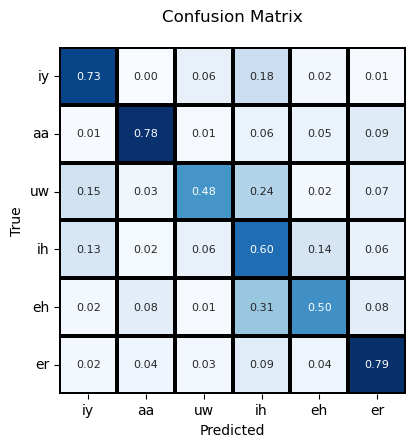

In [22]:
#######################
# modify one of the next four lines to do the requested experiments
feature_selection = slice(0,26)       # default: slice(0,26)       
n_components = 8                   # default: 8
max_iter = 2                       # default: 2
priors =  'training'                  # default: 'training'  (alternative: 'uniform')
######################
# you can also modify other training settings by using this **kwargs{}
#  kwargs = dict(verbose=2,verbose_interval=1)   will print loglik-change (per sample) per iteration
#  kwargs = dict(init_params='random')           will change initialization to random instead of KMeans  (more convergence effort is needed)
#  kwargs = dict(reg_cover=1.e-6,tol=1.e-3)      are some other parameters controlling regularization and a stopping criterion for training
#
kwargs =dict(verbose=2,verbose_interval=1,init_params='kmeans')          
################
X_train = X_train_vow6[:,feature_selection]
y_train = y_train_vow6
X_test = X_test_vow6[:,feature_selection]
y_test = y_test_vow6
classes_used = vow6
# train the model
clf_GMM,_ = train_GMM(X_train, y_train,  classes=classes_used,
                    n_components=n_components, max_iter=max_iter,Verbose=True,**kwargs)
# test the model
acc_test,cm = test_GMM(clf_GMM, X_test, y_test,  Verbose=True, norm=True, priors=priors)

### Exercise 2: Training with all phonemes

##### Things to explore:

- run the training with default parameters
- have a look at the confusion matrix
    + in what range are the per phone accuracies situated ?
    + find the most confusable phone pairs
        - some of the confusable pairs were a bit to be expected; explain 
        - do such confusable pairs hint to problems with phonetic transcriptions or to issues with the pronunciations ? 
        - will such confusable pairs be a big problem in an integrated speech recognition system with lexicon and language model 

Training Set:  Accuracy = 55.68%
Training Set:  LL(per sample) = -30.52
Test Set:      Accuracy = 49.25%


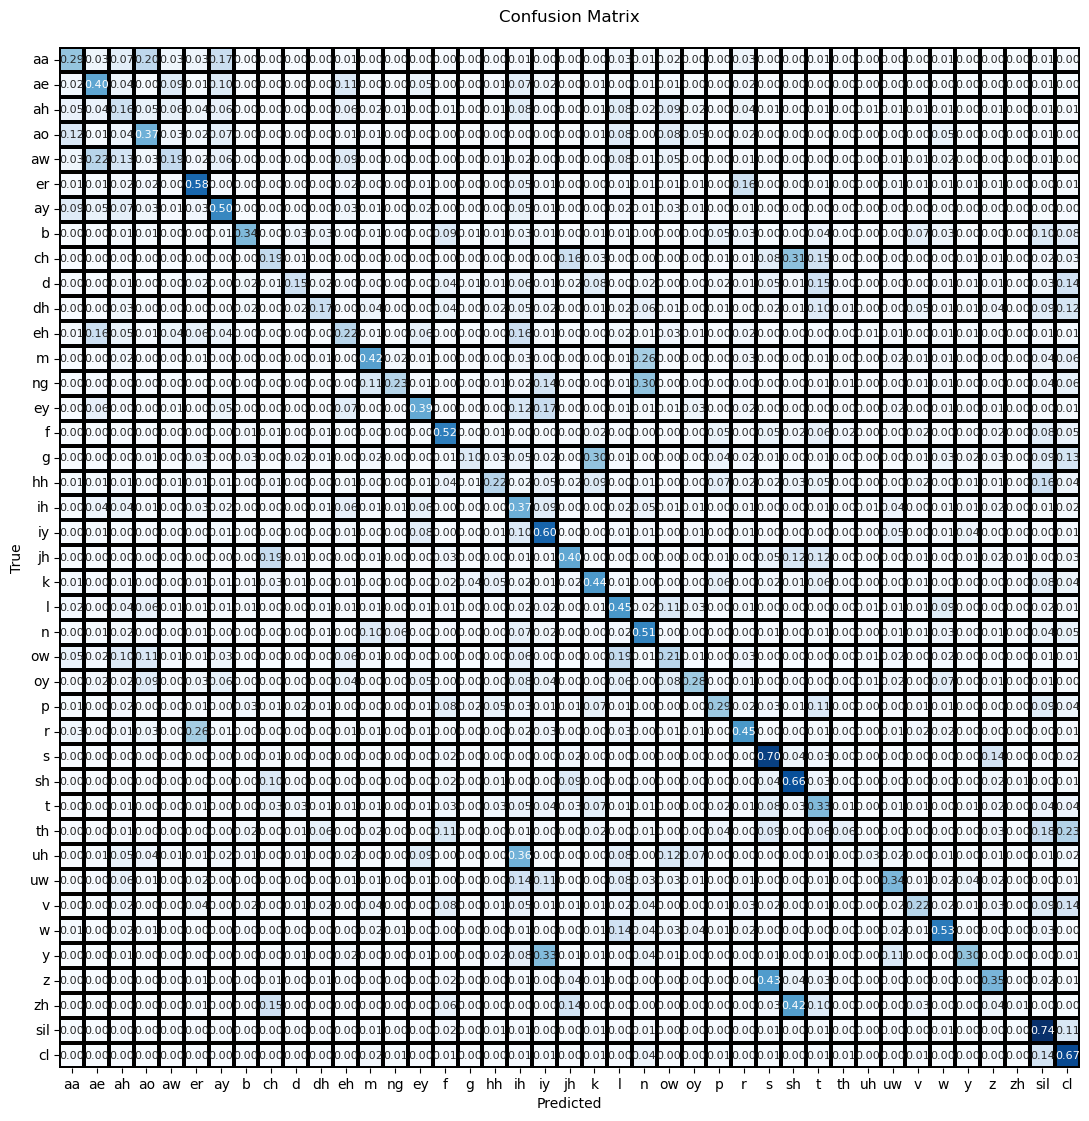

In [84]:
#################
# only modify one of the next four lines to do the requested experiments
feature_selection = slice(0,26)       # default: slice(0,26)       
n_components = 8                      # default: 8
max_iter = 2                          # default: 2
priors =  'training'                  # default: 'training'  (alternative: 'uniform')
################
X_train = X_train_db[:,feature_selection]
y_train = y_train_db
X_test = X_test_db[:,feature_selection]
y_test = y_test_db
classes_used = classes
# train the model
clf_GMM,_ = train_GMM(X_train, y_train,  classes=classes_used,
                    n_components=n_components, max_iter=max_iter, Verbose=True)
# test the model
acc_test,cm = test_GMM(clf_GMM, X_test, y_test,  Verbose=True, norm=True, priors=priors)

## Exercise 3: Using the model in Continuous Speech Recognition

In this part we will use the trained models to compute frame probabilities (likelihoods or posteriors) for an utterance.
Computing these frame probabilities is just a first step towards continuous speech recognition.  
We can evaluate frame recognition rate within a sentence.   
Also we can observe how stable / unstable such observation probabilities are over time.

##### Note on transcriptions and labels
NOTE 1.
One of the labels is 'cl', i.e. closure before a plosive.  These are often present in your transcriptions, e.g.
-  bricks: b r ih cl k s

NOTE 2.
The transcriptions in TIMIT are labels as given by humans listening to very short fragments of an utterance.   Their transcription reflect the sound that they here .  Thus it is NOT a  CANONICAL transcription which is the transcription you find in a dictionary.
As such you may encounter pronunciation variants:
- is: ih s
- is: iy z

##### Questions.
Question 1:
- Select example 2 ("bricks")
- Have a look at the frame probabilites
    + where does the recognizer seems fairly certain
    + assuming  you only have these prob's as your input (i.e. this is what a recognizer gets), what word would you form if you only take into accounts segments of a couple frames that are consistently recognized as the same phone?
    
Question 2:
- Give an example of phonetic confusion that in your opinion will probably not hurt the recognizer when it can use lexical information

In [95]:
# Import a model or reuse one of the models that you have trained above
#######################################################################
# clf_test = get_pickle("GMM_TIMIT_MINI_D26_G8.pk")   # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
clf_test = clf_GMM

In [187]:
# select a test file for analysis
#################################
example = 1
test_files = ['test/dr1/faks0/si2203',  'test/dr8/fcmh1/si1493', 'test/dr4/fadg0/si1279', 'train/dr1/fcjf0/sx307', 'train/dr1/fdaw0/sx236'] #,'train/dr1/fdml0/si1779']
name = test_files[example]
if name == 'test/dr1/faks0/si2203':    # segment selection "for this dive"
    transcrition = "the reasons for this dive are foolish by now"
    segment_transcription = "for this dive"
    phn_sel = np.array(['sil','cl','d','dh','z','s','f','v','r','er','aa','ay','ah','ao','ih']) #'sil','iy','aa','cl'
    frames=[132,209] # [150,250] # #  [160,185]   # [250,350] # 
elif name ==  'test/dr8/fcmh1/si1493':  # segment selection "by that time perhaps something "
    phn_sel = np.array(['sil','cl','b','dh','t','p','s','m','ay','aa','ae','ah','iy','th'])
    phn_sel = np.array(['sil','cl','b','dh','t','p','ay','aa','ae','ah','eh'])
    frames=[10,65]
elif name == 'test/dr4/fadg0/si1279':  # bricks are an alternative
    transcription = "bricks are an alternative"
    segment_transcription = "bricks"
    phn_sel = np.array(['sil','cl','b','dh','t','k','r','l','s','ih','iy','ae','eh'])
    frames = [10,50]
elif name == 'train/dr1/fcjf0/sx307': # the meeting is now adjourned
    transcription = "the meeting is now adjourned"
    segment_transcription = "the meeting is now"
    phn_sel = np.array(['sil','ih','iy','ey','aw','ay','dh','t','s','f','z','ng','n','m']) 
    frames = [5,80]
elif name == 'train/dr1/fdaw0/sx236': # clear pronunciation is appreciated
    transcription = "clear pronunciation is appreciated"
    segment_transcription = "is appreciated"
    phn_sel = np.array(['sil','cl','ah','aw','ae','eh','ey','ih','iy','uh','b','d','dh','p','t','k','r','l','s','sh','ng','n','m'])
    frames = [160,250]
else:
    phn_sel = phnset
    frames = [0,-1]
#
shift = 0.01
indx_sel = [classes.index(phn) for phn in phn_sel]
frame_sel = slice(frames[0],frames[1])
x0 = (frames[0]+.5)*shift

# audio and feature extraction
example_audio, sample_rate = pyspch.audio.load(timit_root + 'audio/' + name + ".wav")
example_spg = pyspch.sp.feature_extraction(example_audio, sample_rate=sample_rate) #, **setup.feature_args)
example_features = pyspch.sp.feature_extraction(example_audio, **feature_args)
# transcription + word segmentation 
# transcription + word segmentation 
example_txt = pyspch.read_txt(timit_root + 'segmentation/' + name + ".txt")
example_wrd = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".wrd", dt=1/sample_rate)
print(example_txt)    
# get reference segmentation and labels , phone segmentation (+ as index)
example_phn = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".phn", fmt="float32", dt=1/sample_rate,xlat='timit61_timit41')
example_lab = pyspch.seg2lbls(example_phn, n_frames=example_features.shape[1],pad_lbl='sil') 

['0 40448 By that time, perhaps something better can be done.']


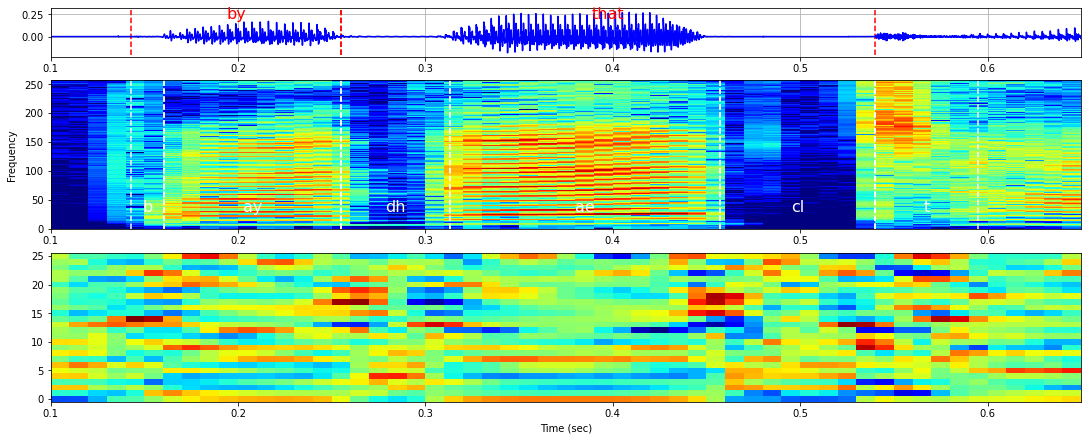

In [188]:
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,
                            frames=frames, sample_rate=sample_rate, figsize=(15,6), img_ftrs=[example_features])
fig.add_seg_plot(example_phn, iax=1, ypos=.15, color='w') 
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=example_audio,rate=sample_rate))

In [189]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
postprob_gmm = clf_test.predict_proba(X=example_features.T)
# evaluate frame based recognition wrt. manual segmentations
y_gmm_idx = np.argmax(postprob_gmm, axis=1)
y_gmm_lab = [classes[i] for i in y_gmm_idx]
# alternative
# y_gmm_lab = clf_GMM.predict(X=example_features.T)
y_gmm_seg = pyspch.lbls2seg(y_gmm_lab)
n_corr = np.sum([y_gmm_lab[i] == example_lab[i] for i in range(len(example_lab))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(example_lab)))

Frame Recognition Rate (for full utterance): 43.25 %


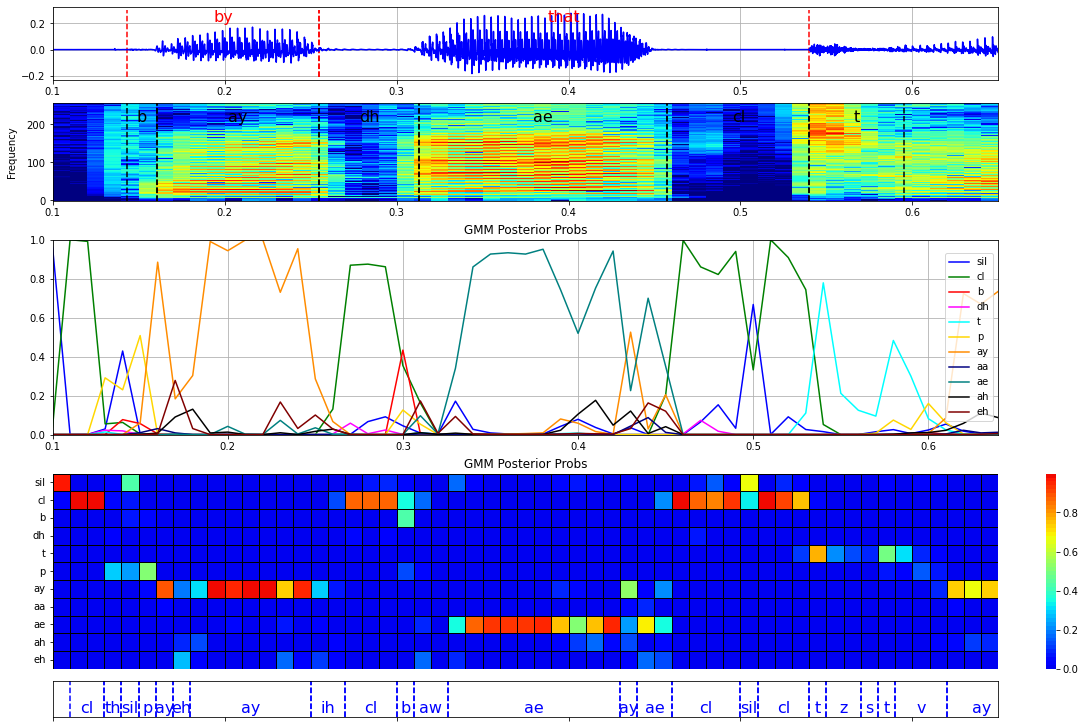

In [195]:
# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,row_heights=[1.5,2,4,4,.75],
                                 frames=frames, sample_rate=sample_rate, figsize=(15,10), img_ftrs=[None,None])
fig.add_seg_plot(example_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*.01, style="line", title="GMM Posterior Probs")
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*.01, style="img", title="GMM Posterior Probs")

fig.add_seg_plot(y_gmm_seg, iax=4, ypos=.25, Lines=True, color='b') # predicted labels
fig

### Baseline DNN model

We use a simple Neural Network (NN) to classify the frames, namely a fully connected feed-forward network, with a sigmoid activation function following each hidden layer. The architecture is defined by the input, output and hidden layer sizes. 

The input feature is a window of 11 frames (black) around the target frame (red) with a stride of 2, giving window that spans 210 ms. 
The stride is distance (in time steps) between the selected frames. 
For each target frames, the selected frames are concatenated into a vector.
Alternatively, one could preserve the 2D structure of the input (time x frequency) provided the neural architecture allows it (e.g. using 2D convolutional layers). 

The phone labels are one-hot encoded, we thus have a neuron for each phone label in the output layer of the network. By applying the softmax function at the end of the network, we obtain phone probabilities as outputs. The predicted label is the one with the highest probabilty. 

Note that training a model from scratch on TIMIT is (relatively) computationally expensive. That is why we load a pretrained model, matching the architecture described above.

<img src="http://homes.esat.kuleuven.be/~spchlab/data_old/timit/dnn_setup_3.PNG" width="750">

#### Setup for baseline

In [ ]:
# baseline
# = mfcc13, delta_delta2, meanvar, 11 frames, stride 2
baseline_path = 'models/default/mfcc13dd2mv/N5s2/' 

# read setup A
# setup_fobj = pyspch.read_fobj(root_url + baseline_path + 'setup.pt')
# setup = read_setup(setup_fobj)

# read setup B
setup_path = baseline_path + 'setup.py'
os.makedirs(baseline_path, exist_ok=True, mode=0o775)
write_from_url(root_url + setup_path, setup_path)
setup = read_setup(setup_path, root_url)

# read checkpoint 
model_fobj = pyspch.read_fobj(root_url + baseline_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)

# unpack checkpoint (model, etc)
model_setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
model.to(device)

#### Data loading

Apart from using a window of frames as input feature for each target frame, we can also normalize and add temporal derrivatives to input feature. 
Here we normalize the variance per channel (and per utterance) and add a first order temporal derrivative (called delta).  

Next we prepare our test data set according to our feature extraction setup.
Note we don't need the training or validation data since we're using a pretrained model.

In [ ]:
# label mapping 
labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 
print(lab2idx)

In [ ]:
# Prepare test set (evaluation)

# corpus
test_corpus = pyspch.read_txt(setup.test_corpus_file)

# read features 
test_df = pd.read_pickle(setup.test_pickle_file)
test_data = pyspch.nn.DataFrame_to_SpchData(test_df, delete_df=True) 

# modify features in corpus
test_data = test_data.subset(test_corpus) 
test_data.modify_features(modify_feature_args) # add delta_delta2, normalize meanvar
test_data.modify_labels(lab2lab) # timit61 -> timit41

In [ ]:
# SpchDataset
test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)
test_ds.encode_target(lab2idx) # one-hot encoding
test_ds.to_tensor()

# Sampler (splicing)
test_lengths = test_data.get_length('features')
test_ds.set_sampler(test_lengths, setup.sampler_args)
test_ds.to_device(device)

# DataLoader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

#### Baseline model evaluation

##### Test set: PER and confusion matrix

In [ ]:
# Confusion matrix
cm = pyspch.nn.evaluate_cm(model, test_dl) 

# Phone Error Rate (PER) + PER per phone class
per, per_pc = pyspch.nn.cm2per(cm)
print("PER %.2f " % (per))
if not None in per_pc:
    print("PER per phone class %s" % (np.round(per_pc, 4)))

# Cross-entropy loss
loss = pyspch.nn.evaluate(model, test_dl, criterion)
print("CE Loss %.2f" % loss)

In [ ]:
# plot (row normalized confusion matrix)
cm_norm = cm / cm.sum(axis=1)[:,None]
pyspch.plot_confusion_matrix(cm_norm, labels, annot=False, figsize=(20,20))

##### Single utterance: phone probabilties

The posterior probabilties are now visualized for one entire utterance below. Because the dataset (after feature extraction) is quite big, we avoid loading unnecessary data. Here we only do the feature extraction for a single utterance.

In [ ]:
# Visualization
pyspch.display.PlotSpg(wavdata=example_audio,sample_rate=sample_rate,spgdata=example_feature, segspg=example_phn)

In [ ]:
# plot only subset of phones (for readability)
long_vowels = ['aw', 'ay', 'er', 'ey', 'iy', 'ow', 'oy', 'uw']
short_vowels = ['aa', 'ao', 'ae', 'ah', 'eh', 'ih', 'uh']

# plot input
if False:
  utt_fig, utt_ax = plt.subplots(figsize=(15, 10))
  utt_ax.matshow(example_X.cpu().detach().numpy().T)

# plot output - posterior probabilities
plot_df = pd.DataFrame(example_yp.cpu().detach().numpy(), columns=labels)
cols = labels
cols = ['sil'] + short_vowels # choose phones to plot (subset) 
# Note: sil = silence and vcl = 'voiced closure' ~ silence
plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3), xlim=[0, example_yp.shape[0]])

# plot output - posterior probabilities
cols = ['sil'] + long_vowels # choose phones to plot (subset) 
plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3), xlim=[0, example_yp.shape[0]])

#### Questions

**Phone mapping**

Q1. What is the effect of reducing the number of phone labels (e.g. from 61 to 48) for training the model? 

**Feature extraction**

Q2. Can we use our pretrained model with a different feature extraction setup?

Q3. What happens to the input feature on the phone boundaries?

Q4. What happens to the input feature on the utterance boundaries?

**Evaluation**

Q5. What is the effect of reducing the number of phone labels from 48 to 39 for evaluating the model? 

<!-- Q6. Given the posterior probabilities for the utterance "The reasons for this dive seemed foolish now", is there a corespondence between the short vowels that are hard to recognize for the model and your own perception? -->


### Effect of input features

Using the same model setup as above, we will now vary the feature extraction setup. Four new setups are considered. Note that we are still loading pretrained models.

#### Setups

In [ ]:
# write multiple pretrained models 

# models/architecture/feature/sampler/
model_paths = ['models/default/mfcc13dd2mv/N5s2/', # 11 frames, stride 2 (210 ms), delta_delta2 (+ 40 ms) 
               'models/default/mel24dd2mv/N5s2/', # 11 frames, stride 2 (210 ms), delta_delta2 (+ 40 ms) 
               'models/default/mel80mv/N5s2/', # 11 frames, stride 2 (210 ms)
               'models/default/mfcc13dd2mv/N0s1/', # 1 frames, stride 2 (10 ms), delta_delta2 (+ 40 ms) 
               'models/default/mel24dd2mv/N0s1/', # 1 frames, stride 2 (10 ms), delta_delta2 (+ 40 ms) 
               'models/default/mel80mv/N0s1/', # 1 frames, stride 2 (10 ms)
               ]

for model_path in model_paths:
    os.makedirs(model_path, exist_ok=True, mode=0o777)
    write_from_url(root_url + model_path + 'setup.py', model_path + 'setup.py')

#### Evaluate and visualize 

In [ ]:
# shared corpus
test_corpus = pyspch.read_txt(setup.test_corpus_file) 

In [ ]:
for model_path in model_paths: 
    
    print(model_path)
    
    ### Model
    
    # read setup 
    setup = read_setup(model_path + 'setup.py', root_url)

    # read checkpoint 
    model_fobj = pyspch.read_fobj(root_url + model_path + 'model.pt')
    checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)
    
    # unpack checkpoint (model, etc)
    model_setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
    model.to(device)
    
    # feature arguments
    read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
    modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)
    
    # label mapping 
    labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
    lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 
    
    ### Single utterance: phone probabilties
    
    # utterance
    example = 'test/dr1/faks0/si2203'
    
    # feature + modification + splicing
    example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
    example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
    example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

    # labels (phone segmentation)
    lab_shift = read_feature_args['f_shift'] * read_feature_args['sample_rate']
    example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32")
    example_lab = pyspch.seg2lbls(example_phn, lab_shift)
    example_lab = [lab2lab[lbl] for lbl in example_lab]
    example_idx = [lab2idx[lbl] for lbl in example_lab] # target
    
    # tensor
    example_X = torch.tensor(example_spliced).T.float().to(device)
    example_y = torch.tensor(example_idx).long().to(device)

    # prediction 
    example_yp = model(example_X) # log probs
    example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs
    
    # plot output - posterior probabilities
    plot_df = pd.DataFrame(example_yp.cpu().detach().numpy())
    plot_df.columns = labels
    cols = plot_df.columns # choose phones to plot
    cols = ['sil'] + short_vowels # + long_vowels # 
    plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3))

    if False:
      
        ## Test set: PER and confusion matrix
        
        # features
        test_df = pd.read_pickle(setup.test_pickle_file) # read all features 
        
        # modify features and labels
        test_data = pyspch.nn.DataFrame_to_SpchData(test_df, delete_df=False)  
        test_data = test_data.subset(test_corpus) # subset by corpus
        test_data.modify_features(modify_feature_args) # modify features
        test_data.modify_labels(lab2lab) # timit61 -> timit41

        # SpchDataset
        test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)
        test_ds.encode_target(lab2idx) # one-hot encoding
        test_ds.to_tensor()

        # Sampler (splicing)
        test_lengths = test_data.get_length('features')
        test_ds.set_sampler(test_lengths, setup.sampler_args)

        # DataLoader
        test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)
        
        # PER and confusion matrix
        loss = pyspch.nn.evaluate(model, test_dl, criterion)
        cm = pyspch.nn.evaluate_cm(model, test_dl) 
        per, per_pc = pyspch.nn.cm2per(cm)
        print("CEL %.2f" % loss)
        print("PER %.2f " % (per))
        pyspch.plot_confusion_matrix(cm, labels, annot=False)

#### Questions

**Example utterance**

Q1. Do you notice a difference in the posterior probabilities for different input features?

Q2. Evaluate the models on the test set (run this only if you have spare time). Do you notice a difference in the PER for different input features? Which feature gives the best performance, and why?


### DNN vs. GMM on single frame 

Last exercise session on phoneme classification, we compared the performance of DNNs and GMMs. Near the end we remarked the toy problem was too small for meaningful conclusions. Here we compare the two models on a subset of TIMIT, namely the short vowels. 

If you want to run small experiments yourself, you can select a subset with only a couple of phonemes (reducing the size of the dataset and the diversity in labels). Here we use the short vowels.

In [ ]:
# subset of phone labels
short_vowels = ['aa', 'ao', 'ae', 'ah', 'eh', 'ih', 'uh']
long_vowels = ['aw', 'ay', 'er', 'ey', 'iy', 'ow', 'oy', 'uw']

In [ ]:
# baseline path
single_frame_path = 'models/default/mfcc13dd2mv/N0s1/'
os.makedirs(single_frame_path, exist_ok=True, mode=0o777)

# setup file
write_from_url(root_url + single_frame_path + 'setup.py', single_frame_path + 'setup.py')
setup = read_setup(single_frame_path + 'setup.py', root_url)

In [ ]:
# feature arguments
read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)

# label mapping 
labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 

In [ ]:

setup.test_pickle_file

#### DNN model

In [ ]:
# model
checkpoint = pyspch.nn.read_checkpoint(single_frame_path + 'model.pt', device)
model_setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
model.to(device)

# feature arguments
read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)

# label mapping 
labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 

### Single utterance: phone probabilties

# utterance
example = 'test/dr1/faks0/si2203'

# feature + modification + splicing
example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

# labels (phone segmentation)
lab_shift = read_feature_args['f_shift'] * read_feature_args['sample_rate']
example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32")
example_lab = pyspch.seg2lbls(example_phn, lab_shift)
example_lab = [lab2lab[lbl] for lbl in example_lab]
example_idx = [lab2idx[lbl] for lbl in example_lab] # target

# tensor
example_X = torch.tensor(example_spliced).T.float().to(device)
example_y = torch.tensor(example_idx).long().to(device)

# prediction 
example_yp = model(example_X) # log probs
example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs

# plot output - posterior probabilities
plot_df = pd.DataFrame(example_yp.cpu().detach().numpy())
plot_df.columns = labels
cols = plot_df.columns # choose phones to plot
cols = ['sil'] + short_vowels # + long_vowels # 
plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3))

if False:
    
    ## Test set: PER and confusion matrix
        
    # PER and confusion matrix
    loss = pyspch.nn.evaluate(model, test_dl, criterion)
    cm = pyspch.nn.evaluate_cm(model, test_dl) 
    per, per_pc = pyspch.nn.cm2per(cm)
    print("CEL %.2f" % loss)
    print("PER %.2f " % (per))
    pyspch.plot_confusion_matrix(cm, labels, annot=False)

#### GMM model

#### Questions

**DNN model**

Q1. Why use early stopping? What happens if you continue training?

**GMM model**

Q2. Does the GMM model's performance increase when using a window of frames as input feature, compared to a single frame, and why? 

**Comparison**

Q2. In the end, is a DNN model better suited for phoneme classification as a GMM model, and why?



